# Aligned SOMs (Implementation Details)

**Authors:**   
Markus Kiesel (01228952)   
Alexander Melem(11809621)   
Laurenz Ruzicka (01619916)   


## Implementation Details

Aligned SOMs aims at training mulitple layers of n SOMs with differently weighted subsets of attributes.
The implementation of the SOM training is closely modelled after the decription in the paper Aligned self-organizing maps by Pampalk, Elias [[1]](#1).

The Alignd SOM implementation uses the well known MiniSom package and trains multiple layers of the MiniSom [[2]](#2). A Layer has in extension to the normal MiniSom implementation the possibility to set initial codebook weights. Furter, the update method is adapted to model the distance between layers. We implemented an online-training algorithm which iteratively traines all layers.

In the follwing sections we will briefly describe the major concepts of the Algind SOM and how we implemented it. We will describe the implementation and effect of the parameters when there is no difference to the normal SOM as implmented in the MiniSom library. All parameters and "public" mehtods of the algorithm have docstrings describing the parameter and method in more detail if some aspects are still unclear from the description.


## Layer Weighting

Two aspects of features in a dataset are differently weightet in different layers of the Alignd SOMs. The first layer uses a weighting ratio between aspect A and aspect B features of 1:0. The middle or center layer, weights both aspects equally. The last layer uses a weighting ratio of 0:1.

We create the weights by layer in the **AlignedSom** class using the method **_create_weights_by_layer**. The **AlignedSom** accepts a parameter **aspect_selection** which has to be a boolean List inidcating if the feature belongs to aspect A (True or 1) or if it belongs to aspect B (False or 0).
The weights of features assigned to aspact A are a linear interpolation of 0 to 1 and the weights of features assinged to aspect B are a linear interpolation from 1 to 0.

## Layer/Codebook inizialization

We create N SOM layers inizializing them identically using the same common codebook but weighting them by the respective layer weight vector. 

The inizialization of the layers in the **AlignedSom** class is done in the method **_create_layers**. The number of layers created can be defined by the parameter **num_layers**. We either crate the common codebook randomly or train the center SOM (trained with unweighted data) and use it as basis for all layer inizializations. This can be changeed by the parameter **codebook_inizialization_type** ("random" or "pretrained").
The weighting of the layers is done by the **weights_by_layer** as explaind in the previous section. One Layer is represented by the **Layer** class which extends the MiniSom algorithm by overwriting the **update** method.

## Training

We train multiple layers of SOMs iteratively with an online-training algorithm. The alogrithm is implemented as follows:
1) select a random layer and a random observation from the dataset
2) select the winning unit in the selected layer based on the weighted feature vector
3) train all layers updating the weights based on the same winning unint
    * the selected layer is updated as in the normal SOM training
    * all other layers update the weights similarly but the update is further influenced by the distance to the selected layer
    * all layers use the weighted feature vector based on their respective layer weights
4) iterate steps 1-3 N times

Instad of directly calling the **train** method of one **Layer** the **AlignedSom** iteratively updates the codebook of differnt layers by calling the **update** method. We archive the updates of the codebook in each **Layer** by changing the **update** method of the MiniSom which now also accepts a parameter **ĺayer_dist** which represents the distance between **Layers** in the stack. 

### Layer distances

The distance of the layers is defined as follows.
* the distance to the layer to iteslf is 1.0 which equals the normal SOM update rule
* the distance to the neighboring layer is a fraction (layer_distance_ratio (default 1/10)) of the distance between neighbooring units in one layer
* the distance is defined by a gaussian function with sigma=1.0

We initailly create the distances between layers in the **AlignedSom** in the method **_create_layer_distances**. We do not reduce the distance between layers during the training time as the neighborhood in one layer because we noticed that neighboring layers would have very different codebook weights.

## Visualization

The visualizations are based on the ones in [PySOMVis](https://github.com/smnishko/PySOMVis).   
In the **visualize.py** module the wrapper function **plot_aligned_som** can be used to plot multiple layers of the SOM next to each other. We always show the first and last layer and desired number of SOMs based on the **num_plots** parameter. The type of visualization can be selected by the **visualization_function** parameter. The implemented options are Hit Histogram (**HitHist**), U-Matrix (**UMatrix**) and Smoothed-Data-Histogram (**SDH**) which are all implemented in the same module.

## References
<a id="1">[1]</a>
Pampalk, Elias.
"Aligned self-organizing maps." Proceedings of the Workshop on Self-Organizing Maps. 2003.   
URL: https://www.researchgate.net/publication/2887633_Aligned_Self-Organizing_Maps

<a id="2">[2]</a>
Vettigli, Giuseppe.
"MiniSom: minimalistic and NumPy-based implementation of the Self Organizing Map." (2018).   
URL: https://github.com/JustGlowing/minisom 

In [1]:
import os, sys
import numpy as np

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
  sys.path.append(module_path)

from src.data import load_dataset
from src.config import config
# todo: remove import
from src.aligned_som import AlignedSom
from src.visualize import plot_aligned_som, SDH

In [2]:
# todo: copy past Layer implementation

In [3]:
# todo: copy paste AligndSOM implementation

In [4]:
# todo: copy past visualization code

# Example on Animals Dataset

We show here a small example on the animals dataset as in the paper "Aligned Self-Organizing Maps" to visually comare our results. The dataset comprises 16 records of different kinds of animals, described by 13 binary-valued attributes. The animals can be categorised into three classes: birds, carnivores, and herbivores.

The features are split into activity (aspect A) and appearance (aspect B) features.   
**activity features**: hunt, run, fly, swim   
**appearance features**: small, medium, big, 2_legs, 4_legs, hair, hooves, mane, feathers 

In [5]:
# define params
SEED = config.SEED
N_LAYERS = 31
SOM_DIM = (3, 4)
TRAIN_STEPS = 1000

# load data
input_data, components, weights, classinfo = load_dataset('animals')
data = input_data['arr']

# aspect A: activity features (hunt, run, fly, swim)
# aspect B: appearance features (small, medium, big, 2_legs, 4_legs, hair, hooves, mane, feathers)
aspect_selection = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

# create and train AligndSom
asom = AlignedSom(
    SOM_DIM,
    data,
    aspect_selection,
    num_layers=N_LAYERS,
    random_seed=SEED)
asom.train(TRAIN_STEPS * N_LAYERS)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31000/31000 [00:28<00:00, 1106.88it/s]


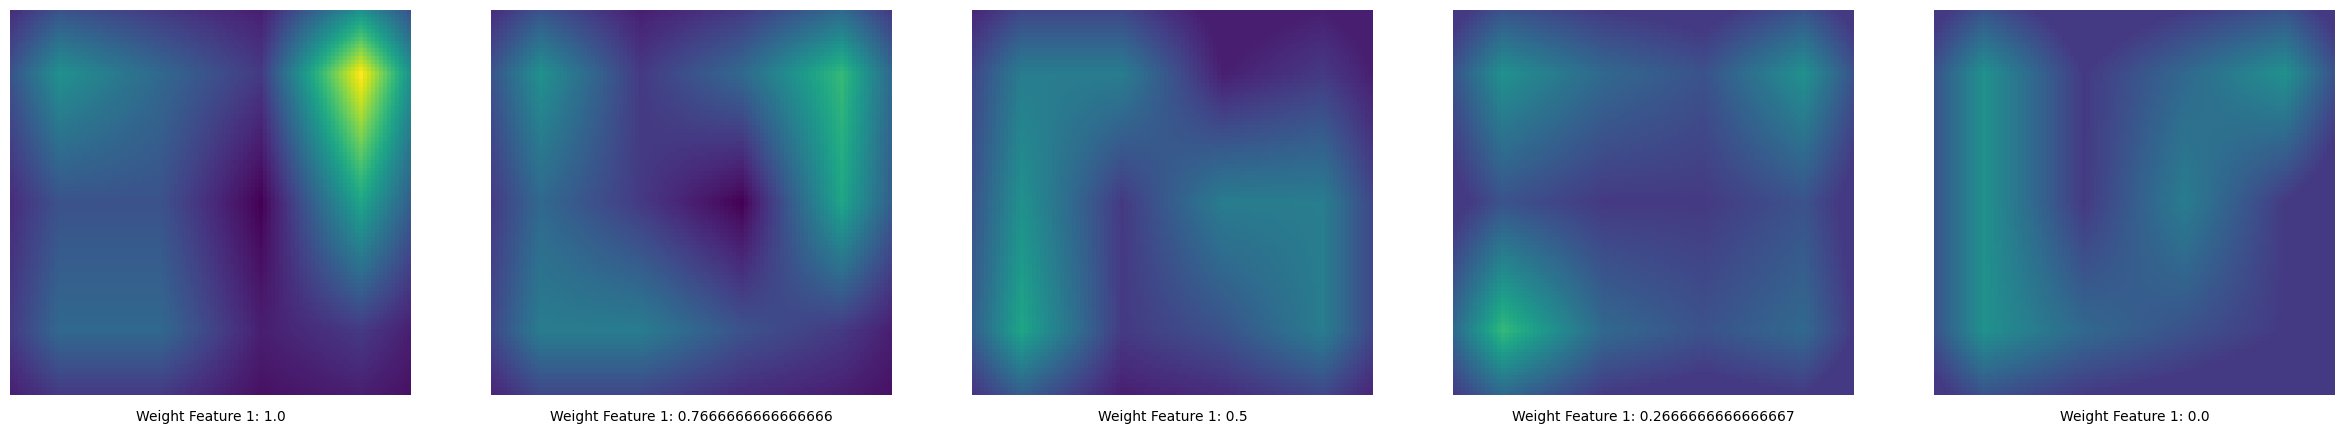

In [6]:
fig = plot_aligned_som(
    asom, data,
    visualization_function=SDH,
    num_plots=5,
    upscaling_factor=100,
    factor=2)